In [1]:
#Playing around w the data more - extra viz (pie charts, histograms, clusters)

import pickle
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import FreqDist
from __future__ import division

%matplotlib inline
sns.set_style("darkgrid")

stop = stopwords.words('english')

In [2]:
with open("cubtweetsDF.pkl", "r") as picklefile:
    CubsDF = pickle.load(picklefile)

In [3]:
#The DF from Thursday - the first one and the one we use for charting in NVD3.
CubsDF.shape

(22396, 6)

In [14]:
#The most popular RT (@Cubs: #Cubs win! Cubs SWEEP!\n\nFinal: Cubs 9, #Brewers 2. #BroomEmoji http://t.co/VvPNcexXKg) was RT'd 1132 times.
#@MLB_ChicagoCubs tweeted the most, with 130 tweets during the game.

In [48]:
RTcount = CubsDF[CubsDF['text'].str.startswith('RT', na=False)]
CubsRTcount = CubsDF[CubsDF['text'].str.startswith('RT @Cubs', na=False)]

RTpercentage = len(RTcount)/len(CubsDF['text'])
CubsRTpercentage = len(CubsRTcount)/len(CubsDF['text'])

len(RTcount), RTpercentage, CubsRTpercentage
#over 49% of all tweets were RTs, and the @Cubs handle was responsible for nearly half of those.
#in fact, RTs of the offical @Cubs handle tweets, accounted for 22% of all tweets.

(10977, 0.4901321664582961, 0.22289694588319342)

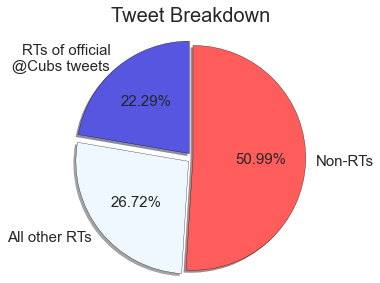

In [727]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

fig = plt.figure(figsize=(4,4))

#lets make a pie chart showing how prominent RTs are
labels = 'RTs of official\n@Cubs tweets', 'All other RTs', 'Non-RTs'
sizes = [CubsRTpercentage*100, (RTpercentage - CubsRTpercentage)*100, (1-RTpercentage)*100]
colors = ['#5656E0', 'aliceblue', '#FF5C5C']
explode = (0.05, 0.05, 0) # only "explode" the 2nd slice (i.e. 'Hogs')

patches, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=90)

for i in texts:
    i.set_fontsize(15)
for i in autotexts:
    i.set_fontsize(15)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title("Tweet Breakdown", fontsize = 20, y=1.06)

plt.savefig("Cubspie.png")
plt.show()

In [4]:
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']

def preprocess(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    #Remove @username
    tweet = re.sub('@[^\s]+',' ',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim by removing single and double quotation marks
    tweet = tweet.strip('\'"')

    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    tweet = pattern.sub(r"\1\1", tweet)
    #remove stopwords - need to break down into words first and then rejoin
    words = TextBlob(tweet).words
    tweet = " ".join([w for w in words if w not in stop])
    
    #some tweets will be empty, so let's replace w the string 'neutral'. This will be neutrally classified.
    
    #encode from unicode to string - only for MonkeyLearn. TextBlob actually wants unicode format.
    
    #currently commented out for textblob.
    #tweet = tweet.encode("utf-8")
    return tweet

In [5]:
CubsDF['text'] = CubsDF['text'].map(preprocess)
print 'Done preprocessing the whole DF.'

Done preprocessing the whole DF.


In [17]:
filtered_tokens = TextBlob(" ".join(list(CubsDF['text']))).words

In [18]:
freq_dist = nltk.FreqDist(filtered_tokens)

#sum(freq_dist.values()) = # of total words = 202870
total = sum(freq_dist.values())

In [19]:
freq_array = pd.Series(freq_dist).order(ascending = False)[:23]

In [20]:
fixed_array = freq_array.drop(freq_array.index[[0,1,7]])

#dropped RT, Cubs, and 's

In [21]:
freq_list = list(freq_dist)

In [22]:
norm_array = fixed_array.map(lambda x:x/total)
# getting the % of word appearances, not just total count.

In [23]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

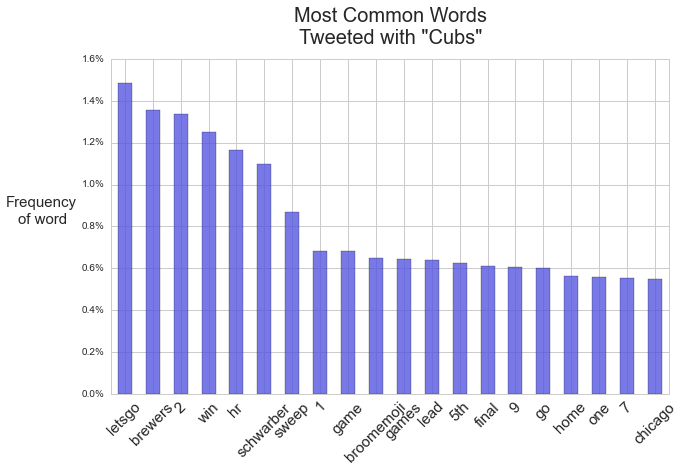

In [24]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)

formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

norm_array.plot(kind = 'bar', use_index=True, color='#5656E0', alpha=0.8)
ax.set_xticklabels(norm_array.index, rotation=45, fontsize = 15)
# ax.invert_yaxis()
plt.title("Most Common Words\nTweeted with \"Cubs\"", fontsize = 20, y=1.03)
plt.ylabel("Frequency\nof word", labelpad = 40, fontsize=15).set_rotation(0)

In [270]:
#word2vec!

In [25]:
alist = [x.split() for x in CubsDF['text']]

#remember that CubsDF['text'] has already been preprocessed.

In [27]:
alist[0]

[u'50', u'u8.5', u'cubs', u'game', u'2']

In [28]:
import gensim

#pass in alist(which is the list of preprocessed tweets), size (the # of vector space dimensions),
#window (the context window size), min_count (the minimum times a word must appear to be considered),
#workers (the number of parallet processing cores to spin up)

model = gensim.models.Word2Vec(alist, size=160, window=8, min_count=3, workers=4, sg=1)

In [29]:
model.most_similar(positive=['schwarber'], topn=10)

[(u'kyle', 0.6900655031204224),
 (u'4', 0.6518419981002808),
 (u'hr', 0.6408111453056335),
 (u'shines', 0.6260446310043335),
 (u'3-4', 0.6092603802680969),
 (u'beat', 0.5845118761062622),
 (u'twice', 0.565845251083374),
 (u'rbi', 0.541997492313385),
 (u'denorfia', 0.506616473197937),
 (u'9-2', 0.5035236477851868)]

In [30]:
model.syn0

array([[  1.08710425e-02,   3.90581903e-04,  -1.00354224e-01, ...,
         -3.43304612e-02,   3.61756571e-02,   5.64492913e-03],
       [ -5.89615442e-02,   2.22718026e-02,  -3.10613234e-02, ...,
         -9.92082153e-03,  -2.47550812e-02,  -2.05398928e-02],
       [  1.35927260e-01,  -2.89231002e-01,  -1.55707568e-01, ...,
          4.21582848e-01,   1.46671101e-01,  -1.63562521e-01],
       ..., 
       [  2.93018320e-03,  -9.18168016e-03,   1.36901625e-03, ...,
          2.16104425e-02,  -1.23523059e-04,  -3.22885672e-03],
       [ -2.70415917e-02,   3.85575630e-02,  -3.34698409e-02, ...,
         -2.63204221e-02,   1.35735446e-03,   3.41299288e-02],
       [ -1.35880604e-03,   1.43448333e-03,  -2.51873862e-04, ...,
          1.91277079e-02,   3.38610401e-03,  -7.99000449e-03]], dtype=float32)

In [31]:
#syn0 is a matrix with a feature vector for each word in the vocabulary - 160 columns because that's what we 
#specified as the number of dimensions we wanted.

#Individual word vectors can be accessed in the following way: model['cubs']

model.syn0.shape

(3606, 160)

In [32]:
from sklearn.cluster import KMeans
import time

start = time.time()

word_vectors = model.syn0
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = 10 )
idx = kmeans_clustering.fit_predict( word_vectors )

end = time.time()
elapsed = end - start
print "Time taken for K Means clustering: ", elapsed, "seconds."

Time taken for K Means clustering:  1.36670303345 seconds.


In [33]:
idx

array([9, 1, 0, ..., 9, 1, 9], dtype=int32)

In [36]:
#index2word is all the words

model.index2word[:5]

[u'weareamazinggood', u'foul', u'four', u'otra', u'lord']

In [37]:
#this is the total # of words in our vocab

# len(model.index2word)

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

In [38]:
len(word_centroid_map.values())

3606

In [48]:
yellowstone = []

for cluster in xrange(0,10):
    # Print the cluster number  
#     print "\nCluster %d" % cluster
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in xrange(0,len(word_centroid_map.values())):
        if( word_centroid_map.values()[i] == cluster ):
            words.append(word_centroid_map.keys()[i])
    if cluster == 7:
        yellowstone.extend(words)
#     print words

In [50]:
#just the non-baseball cluster, delete some error terms
del yellowstone[35]
del yellowstone[32]
del yellowstone[0]

In [51]:
for i in yellowstone:
    print i+",",

dna, murder, ✏🔃, euthanize, nature, defending, mauling, fatal, saveblaze, mother, grizzly, sow, yellowstone, sign, 📜, ht…, euthanized, petition, w/cubs, shows, rehab, zoo, outraged, spare, twin, “maruru”, kill, death, “pororo”, don’t, polar, 萌え死ぬ..（´-`）円山動物園のホッキョクグマの双子「ポロロ」と「マルル」/maruyama, infant, urgent, determines, park, zoo’s, spray, blaze, sent, involved, donotkillblaze, bear, officials, killed, grizzlies, hiker,


In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [53]:
ts = TSNE(2)
#we want two dims

reduced_vecs = ts.fit_transform(model.syn0)

In [54]:
print reduced_vecs.shape
print idx.shape

(3606, 2)
(3606,)


In [55]:
atest = zip(reduced_vecs, idx)

In [56]:
#just so we understand the indexing for when we do the plotting next cell
print atest[0][0]
print atest[0][1]

[ 5.91213642 -1.20519295]
9


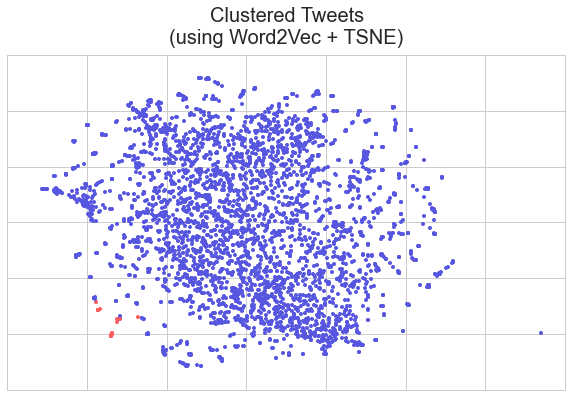

In [57]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)

for i in range(len(reduced_vecs)):
    if atest[i][1] == 3:
        color = '#FF5C5C'
    else:
        color = '#5656E0'

    plt.plot(atest[i][0][0], atest[i][0][1], marker='o', color=color, markersize=4)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.title("Clustered Tweets\n(using Word2Vec + TSNE)", y=1.02, fontsize = 20)

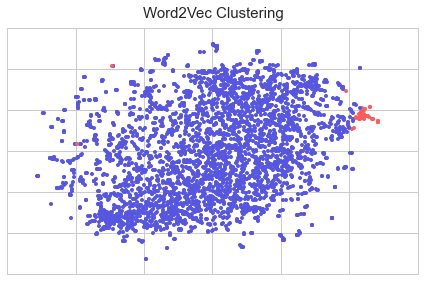

In [666]:
#an alternative - but the other one up top is better.

## model = gensim.models.Word2Vec(alist, size=200, window=5, min_count=3, workers=4, sg=1)

## kmeans_clustering = KMeans( n_clusters = 10 )


# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

# for i in range(len(reduced_vecs)):
#     if atest[i][1] == 5:
#         color = '#FF5C5C'
#     else:
#         color = '#5656E0'

#     plt.plot(atest[i][0][0], atest[i][0][1], marker='o', color=color, markersize=4)
    
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
#     plt.title("Word2Vec Clustering", y=1.02, fontsize = 15)

In [799]:
#lets make a seaborn horizontal barplot for our sentiment analysis app benchmarking

#make our dataframe first
DF = pd.DataFrame({'App':['TextBlob','TextBlob','Aylien','Aylien','AlchemyAPI','AlchemyAPI',
                              'MonkeyLearn','MonkeyLearn','Sementria','Sementria'], 
                  'Input-type':['Raw','Preprocessed','Raw','Preprocessed','Raw','Preprocessed',
                         'Raw','Preprocessed','Raw','Preprocessed'],
                  'Accuracy':[57,57,40,52,52,46,59,65,49,40]})

def color(x):
    if x=='Raw':
        return 'red'
    else:
        return 'blue'
    
DF['colors']=DF['Input-type'].map(color)
DF

,Accuracy,App,Input-type,colors
0,57,TextBlob,Raw,red
1,57,TextBlob,Preprocessed,blue
2,40,Aylien,Raw,red
3,52,Aylien,Preprocessed,blue
4,52,AlchemyAPI,Raw,red
5,46,AlchemyAPI,Preprocessed,blue
6,59,MonkeyLearn,Raw,red
7,65,MonkeyLearn,Preprocessed,blue
8,49,Sementria,Raw,red
9,40,Sementria,Preprocessed,blue


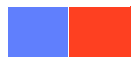

In [832]:
newcolors = sns.choose_diverging_palette()

In [58]:
2+2

4

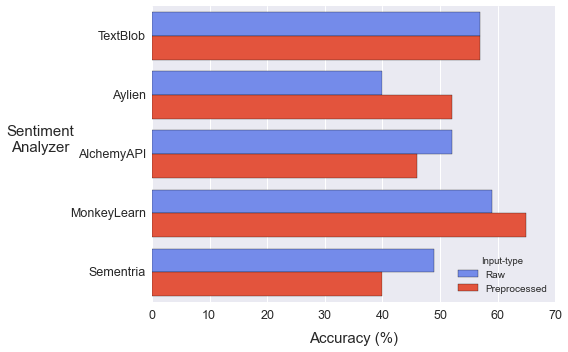

In [835]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(y="App", x="Accuracy", hue="Input-type", data=DF, orient="h", palette=
                 newcolors)
ax.set_ylabel('Sentiment\nAnalyzer', labelpad = 30, fontsize=15).set_rotation(0)
ax.set_xlabel('Accuracy (%)', fontsize=15, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12.5)